In [1]:
import os
from pathlib import Path
from operator import itemgetter
import pickle
import pydicom
from time import time
import pandas

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from catch_converter.parse_contours import parse_cvi42ws
from LazyLuna.Mini_LL import *
from LazyLuna.utils import *
from LazyLuna.Tables  import *
from LazyLuna.Figures import *

import shapely

In [2]:
bp        = '/Users/dietrichhadler/Desktop/Daten/CAMAID'
bp_annos1 = '/Users/dietrichhadler/Desktop/Daten/CAMAID/Gold'
bp_annos2 = '/Users/dietrichhadler/Desktop/Daten/CAMAID/Reader2'
bp_cases  = '/Users/dietrichhadler/Desktop/Daten/CAMAID/Cases'
bp_imgs   = '/Users/dietrichhadler/Desktop/Daten/CAMAID/Imgs'

In [3]:
"""
# unpack the workspaces from ws_path to case_storage_path
for bp_annos in [bp_annos1,bp_annos2]:
    #bp_annos = bp_annos2
    parse_cvi42ws(bp_annos, bp_annos, process=True, debug=False)
    cases = []
    paths = get_imgs_and_annotation_paths(bp_imgs, bp_annos)
    view1 = SAX_T1_View()
    view2 = SAX_T2_View()
    for imgp, annop in paths:
        #if '001_1' not in imgp: continue
        try:
            print(imgp, annop)
            st = time()
            case = Case(imgp, annop, os.path.basename(imgp), os.path.basename(bp_annos))
            view1.initialize_case(case, debug=True)
            view2.initialize_case(case, debug=True)
            case.store(bp_cases)
            cases.append(case)
            print('Case customization took: ', time()-st, 'Case: ', case.reader_name, case.case_name)
        except Exception as e:
            print('Failed at: ', imgp, annop, ' , Exception: ', e)
        print()
        #break
"""

"\n# unpack the workspaces from ws_path to case_storage_path\nfor bp_annos in [bp_annos1,bp_annos2]:\n    #bp_annos = bp_annos2\n    parse_cvi42ws(bp_annos, bp_annos, process=True, debug=False)\n    cases = []\n    paths = get_imgs_and_annotation_paths(bp_imgs, bp_annos)\n    view1 = SAX_T1_View()\n    view2 = SAX_T2_View()\n    for imgp, annop in paths:\n        #if '001_1' not in imgp: continue\n        try:\n            print(imgp, annop)\n            st = time()\n            case = Case(imgp, annop, os.path.basename(imgp), os.path.basename(bp_annos))\n            view1.initialize_case(case, debug=True)\n            view2.initialize_case(case, debug=True)\n            case.store(bp_cases)\n            cases.append(case)\n            print('Case customization took: ', time()-st, 'Case: ', case.reader_name, case.case_name)\n        except Exception as e:\n            print('Failed at: ', imgp, annop, ' , Exception: ', e)\n        print()\n        #break\n"

In [4]:
cases = [pickle.load(open(os.path.join(bp_cases,p), 'rb')) for p in os.listdir(bp_cases)]
cases1 = sorted([c for c in cases if c.reader_name=='Gold'], key=lambda c:c.case_name)
cases2 = sorted([c for c in cases if c.reader_name=='Reader2'], key=lambda c:c.case_name)
print([c.case_name for c in cases1])
print([c.case_name for c in cases2])
print(len(cases1))
print(len(cases2))

v = SAX_T1_View()
#v = SAX_T2_View()
for c_i in range(len(cases1)): 
    print(cases1[c_i].case_name, cases1[c_i].other_categories.keys())
    try: cases1[c_i] = v.customize_case(cases1[c_i])
    except Exception as e: print(e)
print()

for c_i in range(len(cases2)): 
    print(cases2[c_i].case_name, cases2[c_i].other_categories.keys())
    try: cases2[c_i] = v.customize_case(cases2[c_i])
    except Exception as e: print(e)
#cases1 = [v.customize_case(c) for c in cases1]
#cases2 = [v.customize_case(c) for c in cases2]

for c1,c2 in zip(cases1,cases2):
    print(c1.case_name)
    if not hasattr(c1, 'crs') or not hasattr(c2, 'crs'): continue
    for cr1,cr2 in zip(c1.crs,c2.crs):
        print(cr1.name, cr1.get_cr(True), cr2.get_cr(True), cr1.get_cr_diff(cr2,True))
    print()

['CAMAID_001_1', 'CAMAID_002_1', 'CAMAID_003_1', 'Camaid_004_1', 'Camaid_005_1', 'Camaid_006_1', 'Camaid_007_1', 'Camaid_008_1', 'Camaid_009_1', 'Camaid_010_1', 'Camaid_011_1', 'Camaid_014_1', 'Camaid_015_1', 'Camaid_016_1', 'Camaid_017_1']
['CAMAID_001_1', 'CAMAID_002_1', 'CAMAID_003_1', 'Camaid_004_1', 'Camaid_005_1', 'Camaid_006_1', 'Camaid_007_1', 'Camaid_008_1', 'Camaid_009_1', 'Camaid_010_1', 'Camaid_011_1', 'Camaid_014_1', 'Camaid_015_1', 'Camaid_016_1', 'Camaid_017_1']
15
15
CAMAID_001_1 dict_keys(['SAX CINE', 'SAX T1', 'SAX T2'])
CAMAID_002_1 dict_keys(['SAX CINE', 'SAX T1', 'SAX T2'])
CAMAID_003_1 dict_keys(['SAX CINE', 'SAX T1', 'SAX T2'])
Camaid_004_1 dict_keys(['SAX CINE', 'SAX T1', 'SAX T2'])
Camaid_005_1 dict_keys([])
(1, 0)
Camaid_006_1 dict_keys(['SAX CINE', 'SAX T1', 'SAX T2'])
Camaid_007_1 dict_keys(['SAX CINE', 'SAX T1', 'SAX T2'])
Camaid_008_1 dict_keys(['SAX CINE', 'SAX T1', 'SAX T2'])
Camaid_009_1 dict_keys(['SAX CINE', 'SAX T1', 'SAX T2'])
Camaid_010_1 dict_keys

In [5]:
for case1, case2 in zip(cases1, cases2):
    print(case1.case_name, case1.case_name==case2.case_name)
    print(case1.reader_name, case2.reader_name)
    if not hasattr(case1, 'crs') or not hasattr(case2, 'crs'): continue
    cat = case1.categories[0]
    cat2 = case2.categories[0]
    for cr1,cr2 in zip(case1.crs, case2.crs):
        print(cr1.name, cr1.get_cr(string=True), cr2.get_cr(string=True), cr1.get_cr_diff(cr2, string=True))
    m1 = T1AvgDiffMetric()
    m2 = T1AvgReaderMetric()
    m3 = AngleDiffMetric()
    for d in range(cat.nr_slices):
        img1  = cat.get_img  (d, 0, True, False)
        img2  = cat.get_img  (d, 0, True, False)
        anno1 = cat.get_anno (d, 0)
        anno2 = cat2.get_anno(d, 0)
        a = cat.pixel_h*cat.pixel_w
        lvmyo1, lvmyo2 = anno1.get_contour('lv_myo'), anno2.get_contour('lv_myo')
        print(d)
        print('T1Diff val: ', m1.get_val(lvmyo1, lvmyo2, img1, img2))
        print('Reader 1:   ', m2.get_val(lvmyo1, img1))
        print('Reader 2:   ', m2.get_val(lvmyo2, img2))
        print('Angle Diff: ', m3.get_val(anno1, anno2))
        print()
        continue
        fig, ax = plt.subplots(1,1, figsize=(17,17))
        h,w = img.shape
        ax.imshow(img, cmap='gray', extent=(0,w,h,0))
        #anno.plot_all_contour_outlines(ax)
        anno.plot_contour_outlines(ax, 'lv_myo')
        anno.plot_contour_outlines(ax, 'scar_fwhm')
        anno.plot_contour_face(ax, 'scar_fwhm_excluded_area', c='g')
        anno.plot_contour_face(ax, 'excludeEnhancementAreaContour', c='r')
        #anno.plot_contour_face(ax, 'saEnhancementReferenceMyoContour', c='g')
        plt.show()
    print()

CAMAID_001_1 True
Gold Reader2
GLOBAL_T1 1080.37 1081.62 -1.25
NrSlices 3 3 0.00
0
T1Diff val:  12.003968253968196
Reader 1:    1084.3253968253969
Reader 2:    1072.3214285714287
Angle Diff:  0.1119383457692832

1
T1Diff val:  -41.473655817299004
Reader 1:    1085.9179104477612
Reader 2:    1127.3915662650602
Angle Diff:  1.1203678586349575

2
T1Diff val:  23.63152173913045
Reader 1:    1061.4565217391305
Reader 2:    1037.825
Angle Diff:  0.04156102887804357


CAMAID_002_1 True
Gold Reader2
GLOBAL_T1 981.69 982.24 -0.55
NrSlices 3 3 0.00
0
T1Diff val:  -0.7219290780142273
Reader 1:    980.0567375886525
Reader 2:    980.7786666666667
Angle Diff:  1.148153826047033

1


<ipython-input-5-0faa908d6f92>:23: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  print('Angle Diff: ', m3.get_val(anno1, anno2))


T1Diff val:  6.313947953030834
Reader 1:    1002.9891304347826
Reader 2:    996.6751824817518
Angle Diff:  0.975898366107442

2
T1Diff val:  -21.239940387481397
Reader 1:    942.3939393939394
Reader 2:    963.6338797814208
Angle Diff:  0.32536700128200496


CAMAID_003_1 True
Gold Reader2
GLOBAL_T1 984.53 988.33 -3.80
NrSlices 3 3 0.00
0
T1Diff val:  -0.4246502463054185
Reader 1:    979.4433497536946
Reader 2:    979.868
Angle Diff:  0.1311757173650151

1
T1Diff val:  0.8334277391163596
Reader 1:    999.1148648648649
Reader 2:    998.2814371257485
Angle Diff:  0.20251030994612157

2
T1Diff val:  -21.381890687309465
Reader 1:    971.5977011494252
Reader 2:    992.9795918367347
Angle Diff:  0.2704171811290905


Camaid_004_1 True
Gold Reader2
GLOBAL_T1 1054.64 1068.08 -13.44
NrSlices 3 3 0.00
0
T1Diff val:  -10.8639019665261
Reader 1:    1085.3225058004641
Reader 2:    1096.1864077669902
Angle Diff:  1.1235914386313106

1
T1Diff val:  -6.95838054562887
Reader 1:    1047.7818791946308
Reade

CAMAID_001_1
Gold Reader2
GLOBAL_T1 1080.37 1081.62 -1.25
NrSlices 3 3 0.00
Slice:  0


/Users/dietrichhadler/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +
/Users/dietrichhadler/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/Users/dietrichhadler/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


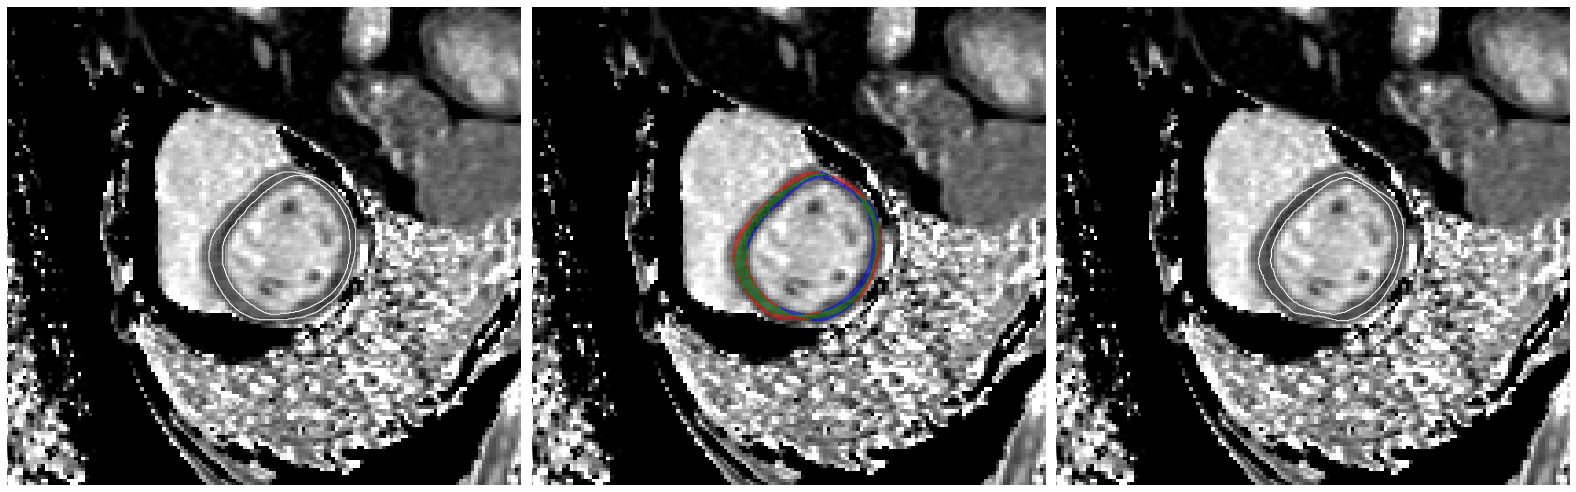

Slice:  1


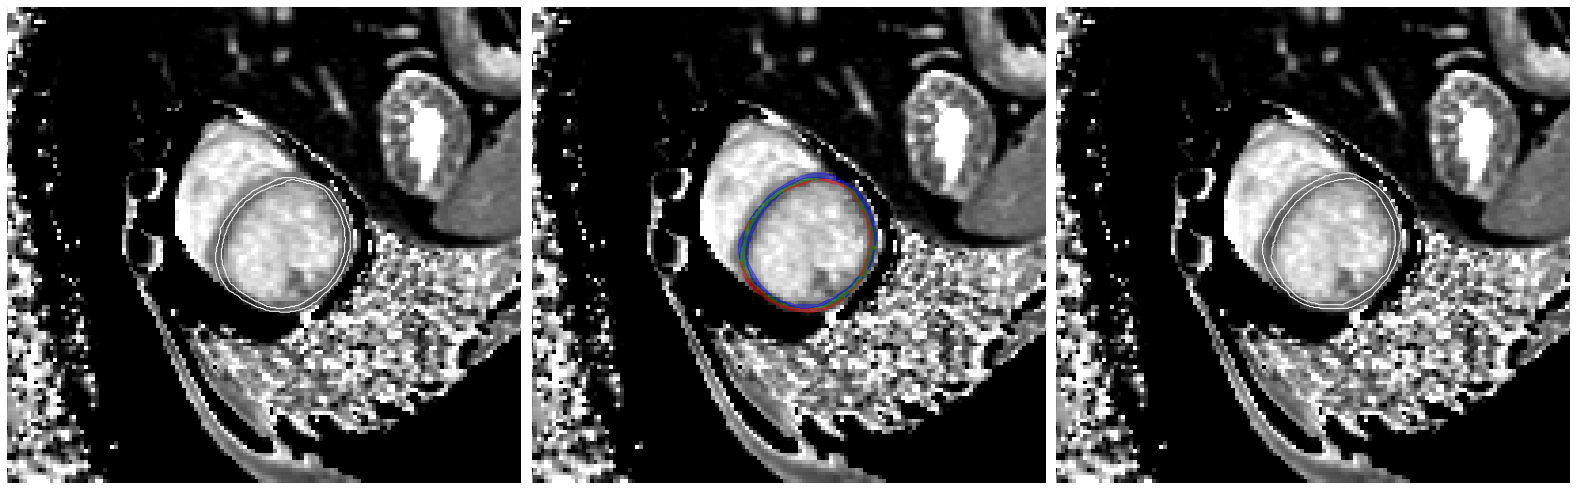

Slice:  2


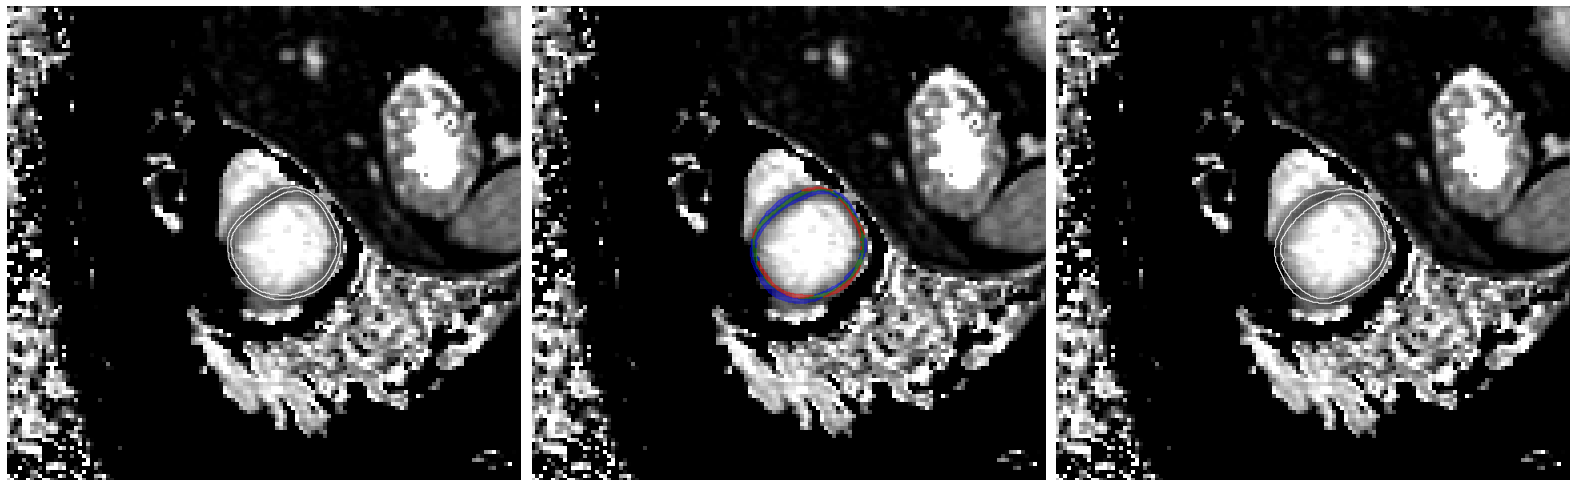

CAMAID_002_1
Gold Reader2
GLOBAL_T1 981.69 982.24 -0.55
NrSlices 3 3 0.00
Slice:  0


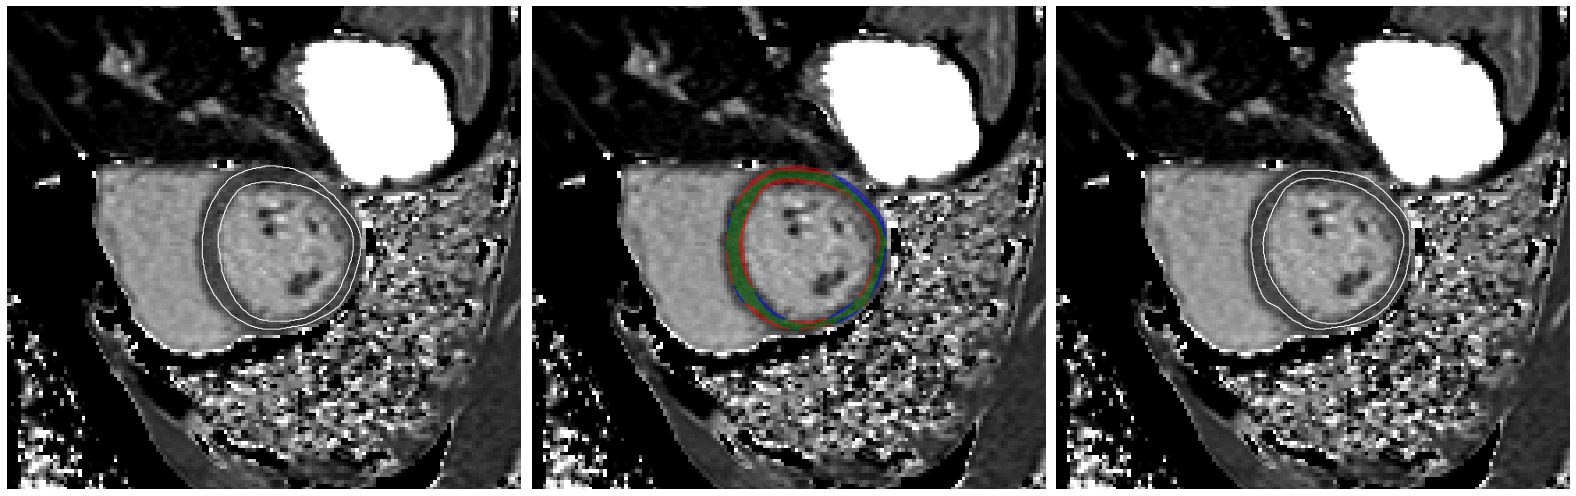

Slice:  1


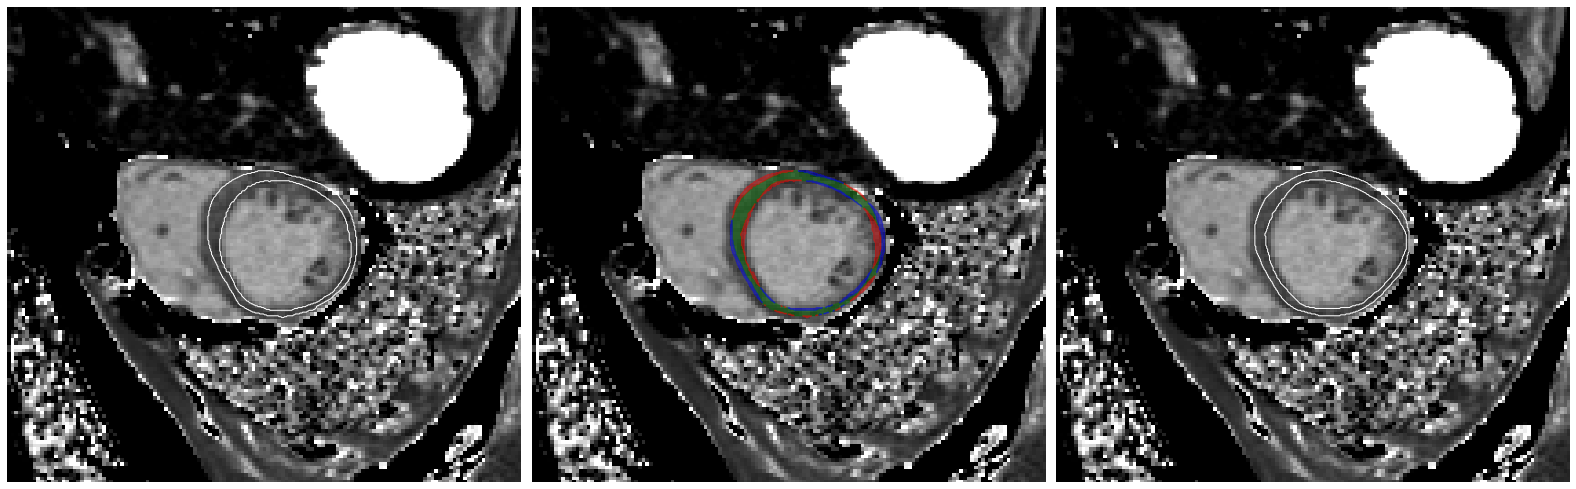

Slice:  2


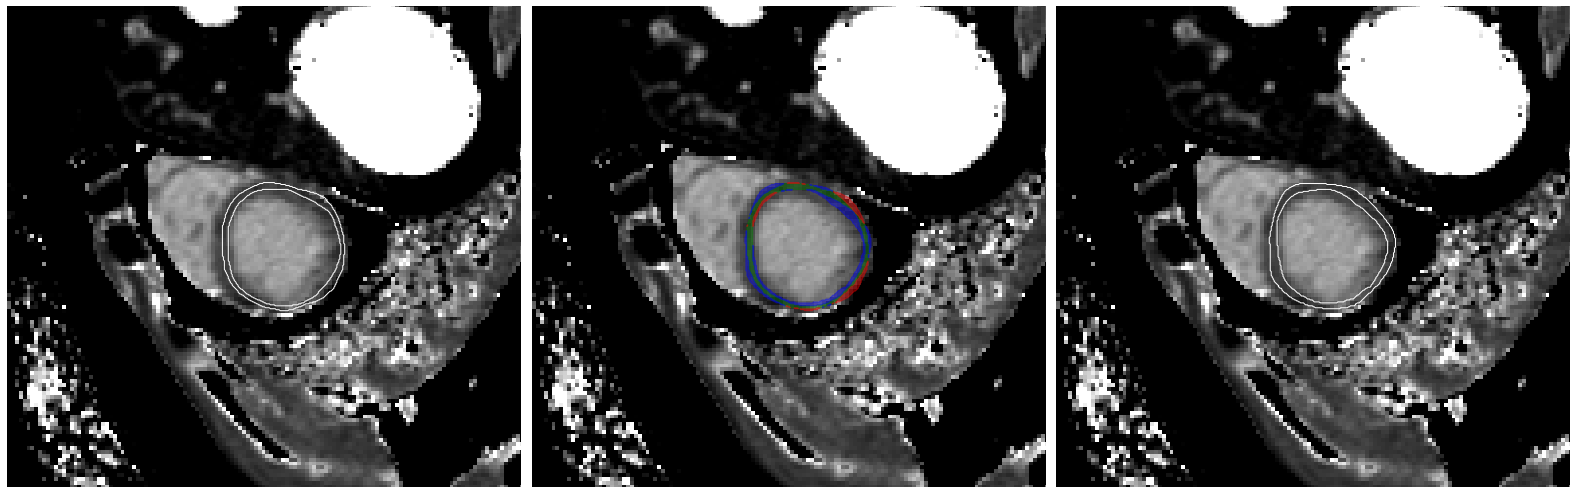

CAMAID_003_1
Gold Reader2
GLOBAL_T1 984.53 988.33 -3.80
NrSlices 3 3 0.00
Slice:  0


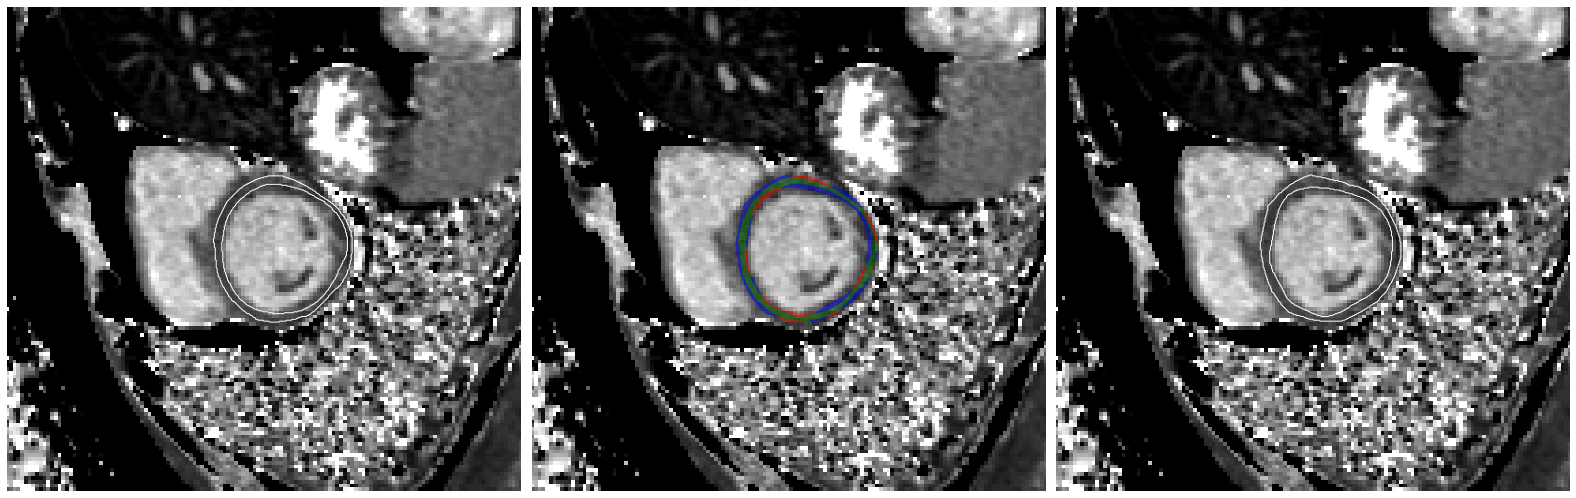

Slice:  1


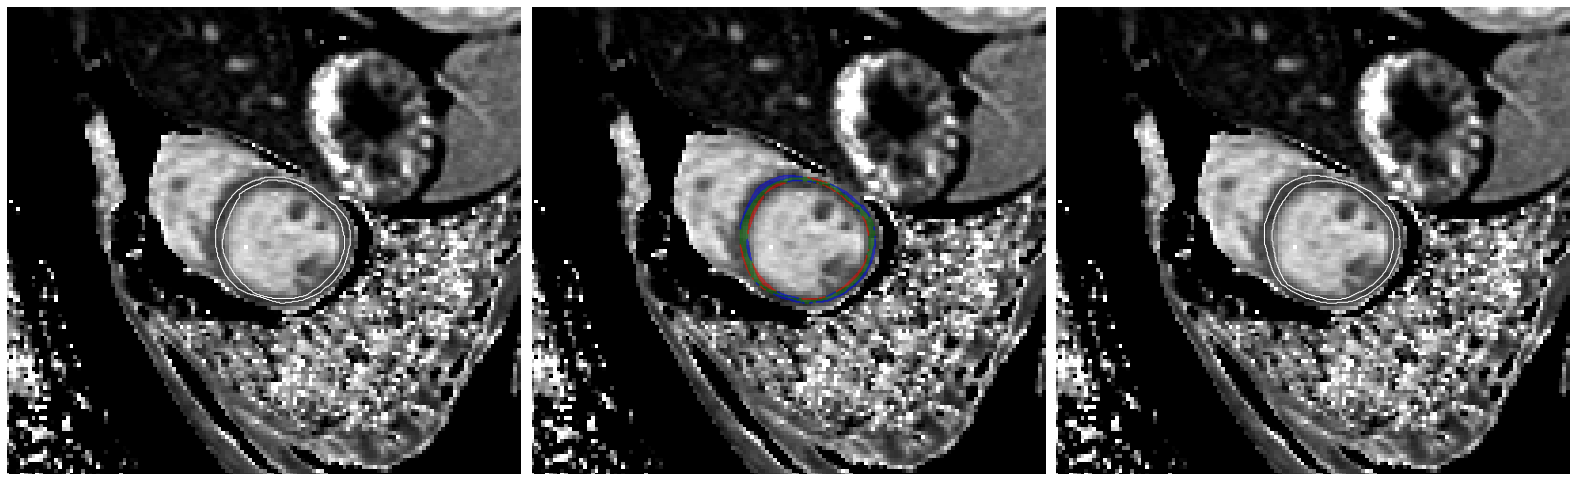

Slice:  2


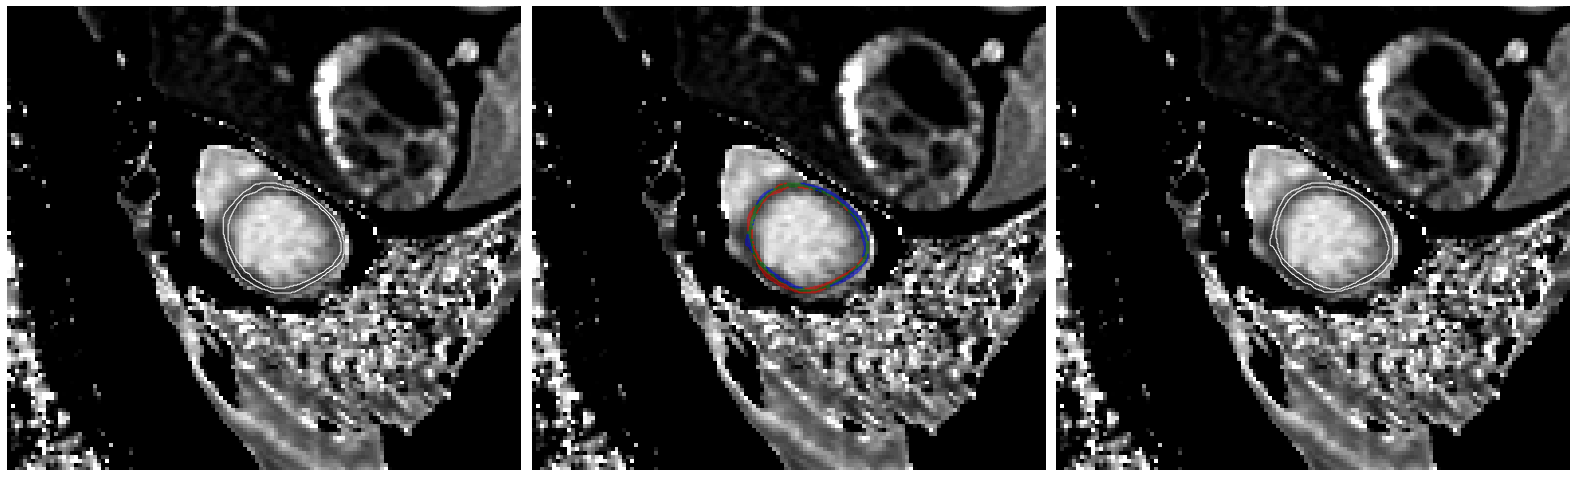

Camaid_004_1
Gold Reader2
GLOBAL_T1 1054.64 1068.08 -13.44
NrSlices 3 3 0.00
Slice:  0


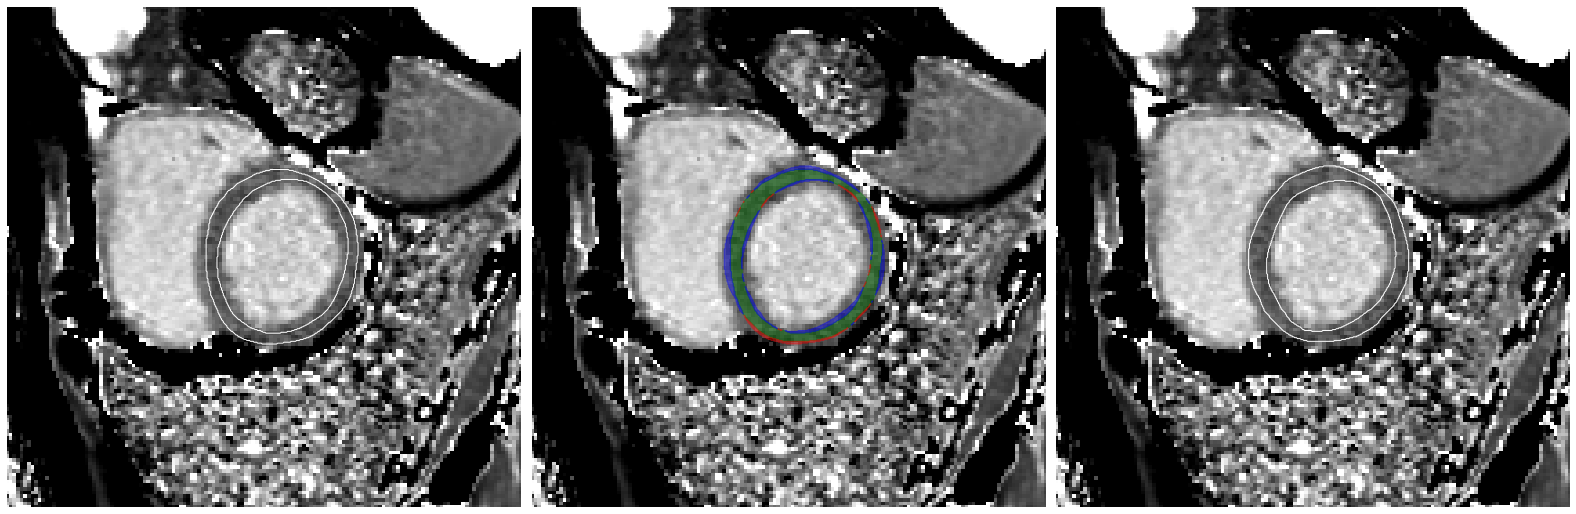

Slice:  1


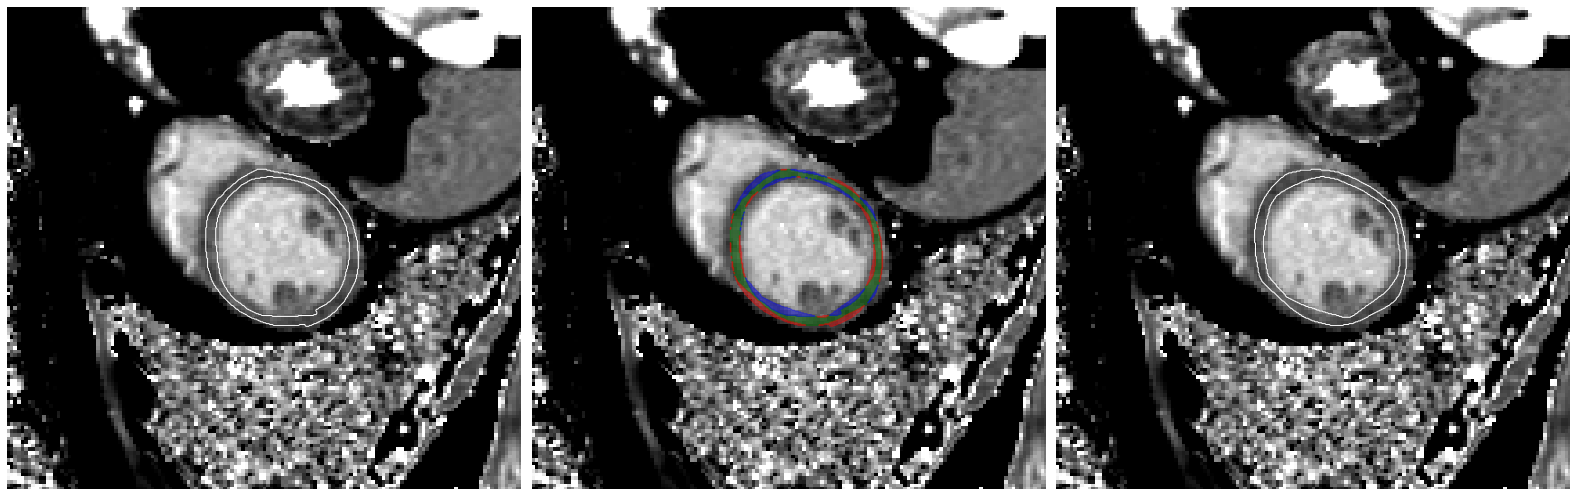

Slice:  2


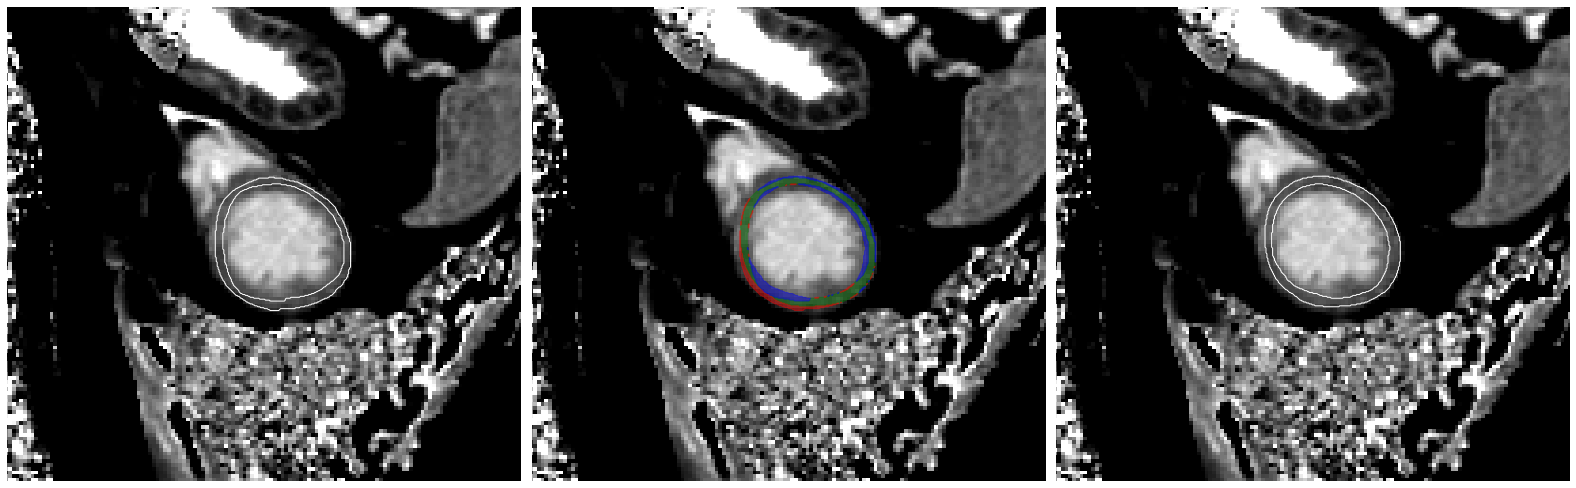

Camaid_005_1
Gold Reader2


KeyError: (1, 0)

In [6]:
for v in [SAX_T1_View(), SAX_T2_View()]:
    for case1, case2 in zip(cases1, cases2):
        print(case1.case_name)
        print(case1.reader_name, case2.reader_name)
        for case in [case1, case2]: v.customize_case(case)
        cat1, cat2 = case1.categories[0], case2.categories[0]
        for cr1, cr2 in zip(case1.crs, case2.crs):
            print(cr1.name, cr1.get_cr(string=True), cr2.get_cr(string=True), cr1.get_cr_diff(cr2, string=True))
        for d in range(cat1.nr_slices):
            print('Slice: ', d)
            img1,  img2  = cat1.get_img (d,0,True,True), cat2.get_img (d,0,True,True)
            anno1, anno2 = cat1.get_anno(d,0), cat2.get_anno(d,0)
            b  = 45
            bb = anno1.get_contour('lv_myo').envelope
            if hasattr(bb, 'exterior'):
                x, y = np.array(bb.exterior.xy)
                lx, ly, ux, uy = x.min()-b-10, y.min()-b, x.max()+b, y.max()+b
            fig, axes = plt.subplots(1,3, figsize=(22,15))
            for ax in axes:  
                ax.imshow(img1, cmap='gray'); ax.axis('off')
                if hasattr(bb, 'exterior'):
                    ax.set_xlim([lx, ux]); ax.set_ylim([ly, uy])
            anno1.plot_contour_outlines(axes[0], 'lv_myo')
            anno1.plot_cont_comparison (axes[1], anno2, 'lv_myo')
            anno2.plot_contour_outlines(axes[2], 'lv_myo')
            fig.tight_layout()
            #fig.savefig(os.path.join(bp, 'Outputs', case1.case_name+'_depth_'+str(d)+'.png'), dpi=300)
            plt.show()
        #break

Slice:  0
POINT (94.75 107.5)


,Reader,Angle Bins,Value
345,R1-R2,"(0°, 120°)",8.553395
591,R1-R2,"(120°, 240°)",-15.457547
800,R1-R2,"(240°, 360°)",-1.067308


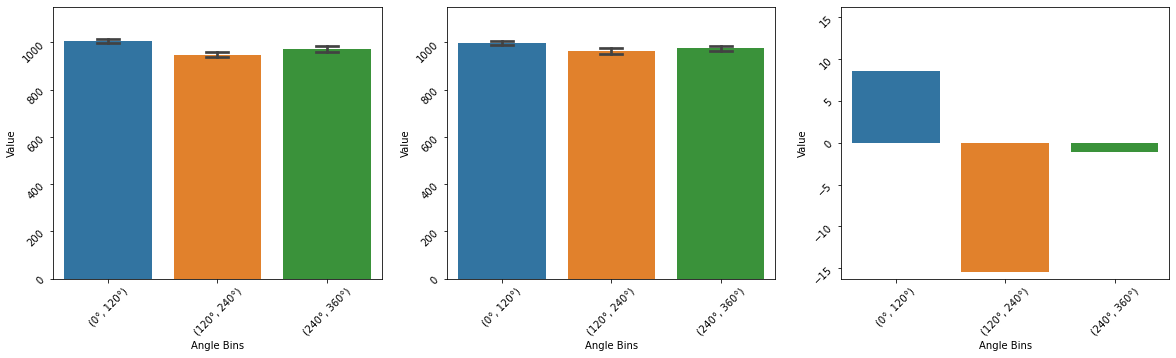

Slice:  1
POINT (92.5 111)


,Reader,Angle Bins,Value
249,R1-R2,"(0°, 120°)",4.408997
422,R1-R2,"(120°, 240°)",-1.336131
552,R1-R2,"(240°, 360°)",17.907971


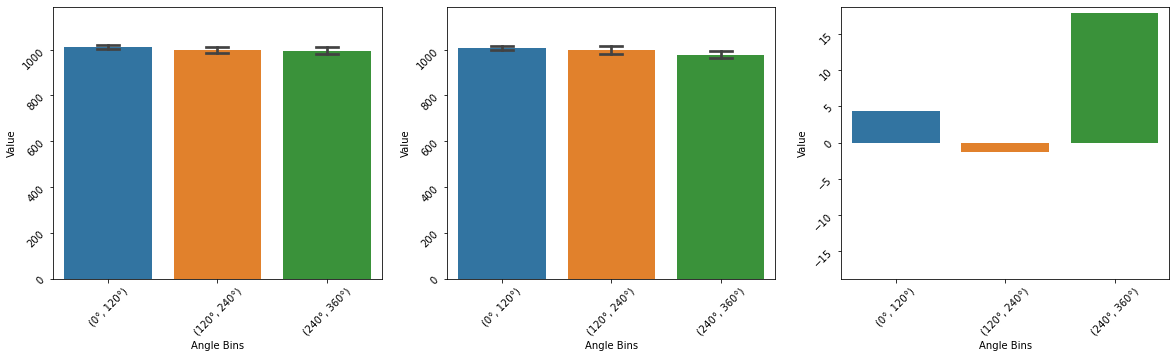

Slice:  2
POINT (90.75 115)


,Reader,Angle Bins,Value
107,R1-R2,"(0°, 120°)",-12.292151
214,R1-R2,"(120°, 240°)",-15.614370
317,R1-R2,"(240°, 360°)",-37.894737


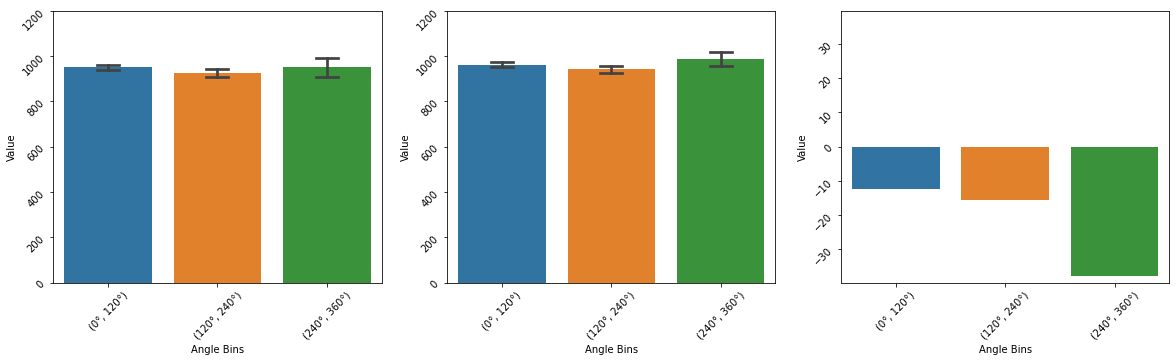

In [7]:
def plot_value_diffs_by_segment(anno1, anno2, img1, img2, nr_segments, byreader=None):
    refpoint = None
    if byreader is not None: refpoint = anno1.get_point('sacardialRefPoint') if byreader==1 else anno2.get_point('sacardialRefPoint')
    print(refpoint)
    myo_vals1 = anno1.get_myo_mask_by_angles(img1, nr_segments, refpoint)
    myo_vals2 = anno2.get_myo_mask_by_angles(img2, nr_segments, refpoint)
    # make vals to pandas table
    rows = []
    for k in myo_vals1.keys():
        for v in myo_vals1[k]:
            row = ['R1', '('+str(int(np.round(k[0])))+'°, '+str(int(np.round(k[1])))+'°)', v]
            rows.append(row)
        for v in myo_vals2[k]:
            row = ['R2', '('+str(int(np.round(k[0])))+'°, '+str(int(np.round(k[1])))+'°)', v]
            rows.append(row)
        row = ['R1-R2', '('+str(int(np.round(k[0])))+'°, '+str(int(np.round(k[1])))+'°)', np.mean(myo_vals1[k])-np.mean(myo_vals2[k])]
        rows.append(row)
    columns = ['Reader', 'Angle Bins', 'Value']
    df = pandas.DataFrame(rows, columns=columns)
    display(df[df['Reader']=='R1-R2'])
    #display(df)
    fig, axes = plt.subplots(1,3, figsize=(20,5))
    sns.barplot(x='Angle Bins', y='Value', data=df[df['Reader']=='R1'],    ax=axes[0], capsize=.2)
    sns.barplot(x='Angle Bins', y='Value', data=df[df['Reader']=='R2'],    ax=axes[1], capsize=.2)
    sns.barplot(x='Angle Bins', y='Value', data=df[df['Reader']=='R1-R2'], ax=axes[2], capsize=.2)
    ymax = df['Value'].mean() + df['Value'].std()*2
    axes[0].set_ylim([0, ymax]); axes[0].tick_params(rotation=45)
    axes[1].set_ylim([0, ymax]); axes[1].tick_params(rotation=45)
    ymin = df[df['Reader']=='R1-R2']['Value'].min()
    ymax = df[df['Reader']=='R1-R2']['Value'].max()
    ymin, ymax = min(ymin, -ymax)*1.05, max(-ymin, ymax)*1.05
    axes[2].tick_params(rotation=45)
    axes[2].set_ylim([ymin, ymax])
    plt.show()
    
v = SAX_T1_View()
case1, case2 = cases1[1], cases2[1]
case1 = v.customize_case(case1)
case2 = v.customize_case(case2)
cat1, cat2 = case1.categories[0], case2.categories[0]
nr_segments = 3
for d in range(cat1.nr_slices):
    print('Slice: ', d)
    img1,  img2  = cat1.get_img (d,0,True,False), cat2.get_img (d,0,True,False)
    anno1, anno2 = cat1.get_anno(d,0), cat2.get_anno(d,0)
    plot_value_diffs_by_segment(anno1, anno2, img1, img2, nr_segments, 2)

Slice:  0


/Users/dietrichhadler/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +
/Users/dietrichhadler/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/Users/dietrichhadler/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


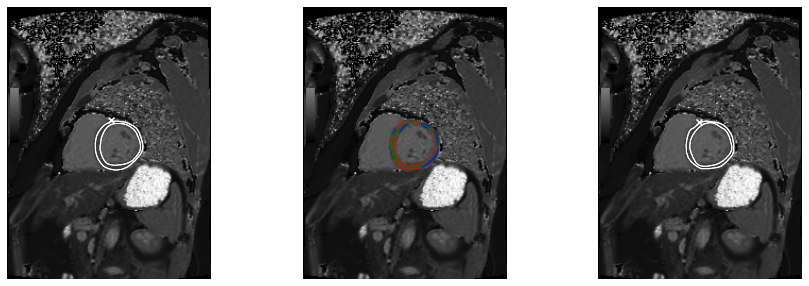

256 192
(256, 192) (256, 192)


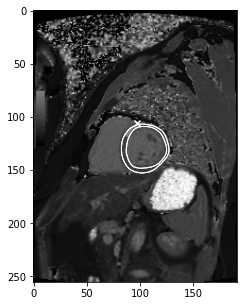

Slice:  1


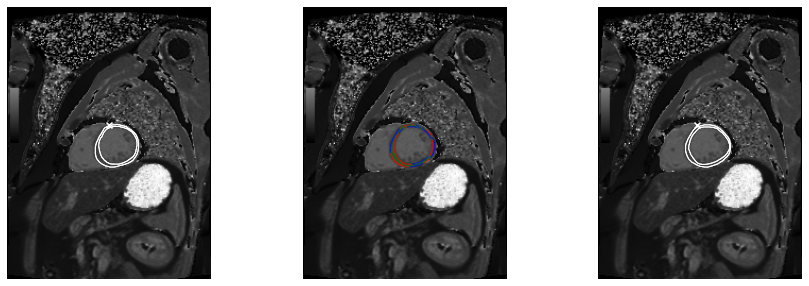

256 192
(256, 192) (256, 192)


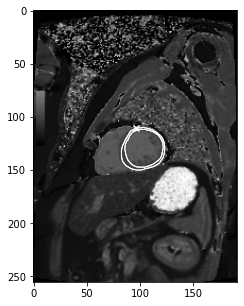

Slice:  2


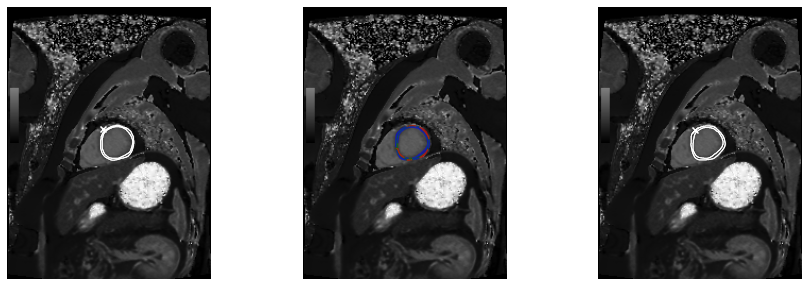

256 192
(256, 192) (256, 192)


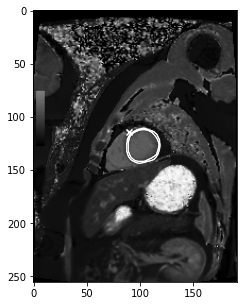

In [8]:
v     = SAX_T1_View()
case1, case2 = cases1[1], cases2[1]
case1 = v.customize_case(case1)
case2 = v.customize_case(case2)
cat1, cat2  = case1.categories[0], case2.categories[0]
nr_segments = 3
for d in range(cat1.nr_slices):
    print('Slice: ', d)
    img1,  img2  = cat1.get_img (d,0,True,False), cat2.get_img (d,0,True,False)
    anno1, anno2 = cat1.get_anno(d,0), cat2.get_anno(d,0)
    fig, axes    = plt.subplots(1,3,figsize=(15,5))
    for j in range(3): axes[j].imshow(img1, cmap='gray'); axes[j].axis('off')
    anno1.plot_all_contour_outlines(axes[0])
    anno1.plot_point(axes[0], 'sacardialRefPoint')
    anno2.plot_all_contour_outlines(axes[2])
    anno1.plot_cont_comparison(axes[1], anno2, 'lv_myo')
    anno2.plot_point(axes[2], 'sacardialRefPoint')
    plt.show()
    h, w     = img1.shape
    print(h,w)
    mask     = anno1.get_angle_mask_to_middle_point_by_reference_point(h,w,None)
    myo_mask = anno1.get_cont_as_mask('lv_myo', h,w)
    print(mask.shape, myo_mask.shape)
    mask_idxs = (mask>0) & (mask<40) & (myo_mask!=0)
    partial_mask = np.zeros((h,w)); partial_mask[mask_idxs]=1
    fig, ax = plt.subplots(1,1,figsize=(15,5))
    ax.imshow(img1+1000*partial_mask, cmap='gray')
    anno1.plot_all_contour_outlines(ax)
    anno1.plot_point(ax, 'sacardialRefPoint')
    plt.show()

In [9]:
def calc_mapping_aha_model(cat):
    if cat.nr_slices == 1:
        print('AHA assuming single midv slice.')
        img, anno = cat.get_img(0,0,True,False), cat.get_anno(0,0)
        m = anno.get_myo_mask_by_angles(img, nr_bins=6)
        m = np.asarray([np.mean(v) for v in b.values()])
        return [np.full(6,np.nan), np.roll(m,1), np.full(4,np.nan)]
    
    if cat.nr_slices == 3:
        # assume 3 of 5 so: 0:base, 1:midv, 2:apex
        print('AHA as three individual slices.')
        img, anno = cat.get_img(0,0,True,False), cat.get_anno(0,0)
        b = anno.get_myo_mask_by_angles(img, nr_bins=6)
        b = np.asarray([np.mean(v) for v in b.values()])
        img, anno = cat.get_img(1,0,True,False), cat.get_anno(1,0)
        m = anno.get_myo_mask_by_angles(img, nr_bins=6)
        m = np.asarray([np.mean(v) for v in m.values()])
        img, anno = cat.get_img(2,0,True,False), cat.get_anno(2,0)
        a = anno.get_myo_mask_by_angles(img, nr_bins=4)
        a = np.asarray([np.mean(v) for v in a.values()])
        return [np.roll(b,1),np.roll(m,1),np.roll(a,1)]
    
    # else nr slices > 3 OR nr slices == 2
    min_dists = cat.get_slice_distances_to_extent_points()
    if min_dists is None: 
        print('No extent & apical points in long axis views. No AHA possible.')
        return [np.full(6,np.nan), np.full(6,np.nan), np.full(4,np.nan)]
    idxs      = np.argmin(min_dists, axis=1)
    weights   = [1/x if x!=0 else np.nan for x in np.bincount(idxs)]
    results = [np.zeros(6) if 0 in idxs else np.full(6,np.nan),
               np.zeros(6) if 1 in idxs else np.full(6,np.nan),
               np.zeros(4) if 2 in idxs else np.full(4,np.nan)]
    for d, idx in enumerate(idxs):
        nr_bins = 4 if idx==2 else 6
        img, anno = cat.get_img(d,0,True,False), cat.get_anno(d,0)
        vs = anno.get_myo_mask_by_angles(img, nr_bins=nr_bins)
        vs = np.asarray([np.mean(v) for v in vs.values()])
        results[idx] += weights[idx] * vs,1
    print('AHA via extent & apical points in long axis view.')
    return [np.roll(r,1) for r in results]

In [10]:
v        = SAX_T1_View()
case1    = v.customize_case(cases1[6])
cat      = case1.categories[0]
aha_data = cat.calc_mapping_aha_model()
aha_data = aha_data[0]
print(aha_data[0])

aha_means = np.concatenate((aha_data[0],aha_data[1],aha_data[2]))
print(len(aha_means))
print(aha_means)

fig = T1_bullseye_plot()
fig.case = case1
ax = fig.visualize()
plt.show()

AHA as three individual slices.
[1023.95945946 1030.92857143 1010.81927711 1034.91304348 1020.1627907
 1077.16666667]
16
[1023.95945946 1030.92857143 1010.81927711 1034.91304348 1020.1627907
 1077.16666667 1019.19354839 1044.92857143 1008.74666667 1033.92857143
 1035.15       1055.30769231  928.12       1007.26923077  970.10810811
  966.58536585]
AHA as three individual slices.
None None
928.12 1077.1666666666667


/Users/dietrichhadler/Documents/GitHub/LazyLuna/src/LazyLuna/Figures.py:928: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(theta0, r0, z, cmap=cmap, norm=norm)
/Users/dietrichhadler/Documents/GitHub/LazyLuna/src/LazyLuna/Figures.py:940: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(theta0, r0, z, cmap=cmap, norm=norm)
/Users/dietrichhadler/Documents/GitHub/LazyLuna/src/LazyLuna/Figures.py:952: MatplotlibDeprecationWarning: shading

In [13]:
def visualize(cc, segBold=[], minv=None, maxv=None):
    cat1 = cc.case1.categories[0]
    cat2 = cc.case2.categories[0]
    means1, stds1 = cat1.calc_mapping_aha_model()
    means2, stds2 = cat2.calc_mapping_aha_model()

    means = np.concatenate((means1[0]-means2[0],
                            means1[1]-means2[1],
                            means1[2]-means2[2]))
    stds  = np.concatenate((stds1[0]-stds2[0], 
                            stds1[1]-stds2[1], 
                            stds1[2]-stds2[2]))

    fig, ax = plt.subplots(1,1, subplot_kw=dict(projection='polar'), figsize=(7,7))
    cmap = plt.cm.bwr
    if minv is None: minv=np.min(means)-5
    if maxv is None: maxv=np.max(means)+5
    minv, maxv = min([minv, -maxv]), max([maxv, -minv])
    norm = colors.Normalize(vmin=minv, vmax=maxv)
    means = np.array(means).ravel()
    stds  = np.array(stds) .ravel()
    theta = np.linspace(0, 2*np.pi, 768)
    r = np.linspace(0.2, 1, 4)
    linewidth = 2
    for i in range(r.shape[0]): ax.plot(theta, np.repeat(r[i], theta.shape), '-k', lw=linewidth)
    for i in range(6):
        theta_i = i * 60 * np.pi/180
        ax.plot([theta_i, theta_i], [r[1], 1], '-k', lw=linewidth)
    for i in range(4):
        theta_i = i * 90 * np.pi/180 - 45*np.pi/180
        ax.plot([theta_i, theta_i], [r[0], r[1]], '-k', lw=linewidth)
    r0 = r[2:4]
    r0 = np.repeat(r0[:,np.newaxis], 128, axis=1).T
    for i in range(6):
        theta0 = theta[i*128:i*128+128] + 60*np.pi/180 #+ 60*np.pi/180
        theta0 = np.repeat(theta0[:,np.newaxis], 2, axis=1)
        #write_val(ax, means[i], stds[i], i*60*np.pi/180 + 30*np.pi/180 + 60*np.pi/180, np.mean(r0[0]))
        z = np.ones((128,2)) * means[i]
        ax.pcolormesh(theta0, r0, z, cmap=cmap, norm=norm)
        if i+1 in segBold:
            ax.plot(theta0, r0, '-k', lw=linewidth+2)
            ax.plot(theta0[0 ], [r[2],r[3]], '-k', lw=linewidth+1)
            ax.plot(theta0[-1], [r[2],r[3]], '-k', lw=linewidth+1)
    r0 = r[1:3]
    r0 = np.repeat(r0[:,np.newaxis], 128, axis=1).T
    for i in range(6):
        theta0 = theta[i*128:i*128+128] + 60*np.pi/180 #+ 60*np.pi/180
        theta0 = np.repeat(theta0[:,np.newaxis], 2, axis=1)
        #write_val(ax, means[i+6], stds[i+6],  i*60*np.pi/180 + 30*np.pi/180 + 60*np.pi/180, np.mean(r0[0]))
        z = np.ones((128,2)) * means[i+6]
        ax.pcolormesh(theta0, r0, z, cmap=cmap, norm=norm)
        if i+7 in segBold:
            ax.plot(theta0, r0, '-k', lw=linewidth+2)
            ax.plot(theta0[0 ], [r[1],r[2]], '-k', lw=linewidth+1)
            ax.plot(theta0[-1], [r[1],r[2]], '-k', lw=linewidth+1)
    r0 = r[0:2]
    r0 = np.repeat(r0[:,np.newaxis], 192, axis=1).T
    for i in range(4):
        theta0 = theta[i*192:i*192+192] + 45*np.pi/180  #+ 90*np.pi/180 
        theta0 = np.repeat(theta0[:,np.newaxis], 2, axis=1)
        #write_val(ax,means[i+12], stds[i+12], i*90*np.pi/180 + 90*np.pi/180, np.mean(r0[0]))
        z = np.ones((192,2)) * means[i+12]
        ax.pcolormesh(theta0, r0, z, cmap=cmap, norm=norm)
        if i+13 in segBold:
            ax.plot(theta0, r0, '-k', lw=linewidth+2)
            ax.plot(theta0[0 ], [r[0],r[1]], '-k', lw=linewidth+1)
            ax.plot(theta0[-1], [r[0],r[1]], '-k', lw=linewidth+1)
    ax.set_ylim([0, 1])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    axp    = ax.imshow(np.random.randint(0, 100, (100, 100)))
    cbaxes = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # This is the position for the colorbar
    cb     = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm), ax=axp, cax=cbaxes)

def write_val(ax, mean, std, angle, y):
    mean = "{:.1f}".format(float(mean))
    std  = "{:.1f}".format(float(std))
    ax.annotate(str(mean) + '\n(' + str(std) + ')',
            xy                  = (angle, y), # theta, radius
            xytext              = (angle, y), # fraction, fraction
            textcoords          = 'data',     #'figure fraction',
            bbox                = dict(boxstyle="round", fc="1.0", edgecolor="1.0"),
            horizontalalignment = 'center',
            size                = 11,
            verticalalignment   = 'center',
            )

AHA as three individual slices.
AHA as three individual slices.


<ipython-input-13-0f73b039c3ed>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(theta0, r0, z, cmap=cmap, norm=norm)
<ipython-input-13-0f73b039c3ed>:51: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(theta0, r0, z, cmap=cmap, norm=norm)
<ipython-input-13-0f73b039c3ed>:63: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilatera

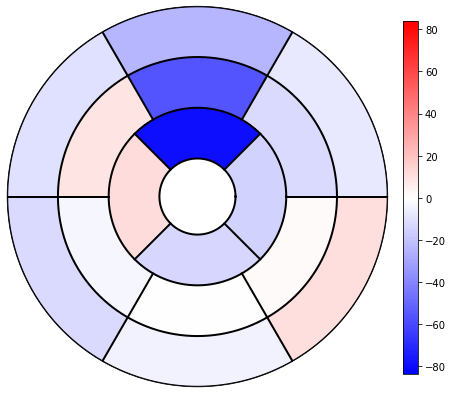

In [15]:
cc = Case_Comparison(cases1[3], cases2[3])
visualize(cc, minv=None, maxv=None)

['GLOBAL_T1', 'NrSlices']


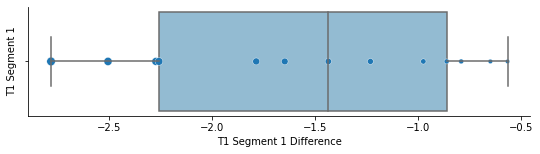

In [16]:
def boxplot():
    fig, ax = plt.subplots(1,1,figsize=(9,2))
    swarm_palette   = sns.color_palette(["#061C36", "#061C36"])
    custom_palette  = sns.color_palette("Blues")[2:]

    rows = []
    for i in range(13):
        rows.append(['T1 Segment 1', 2.4*np.random.rand()-1.2-1.6])
    df = DataFrame(rows, columns=['T1 Segment 1', 'T1 Segment 1 Difference'])
    sns.boxplot(ax=ax, x='T1 Segment 1 Difference', data=df, 
                palette=custom_palette, width=0.13)
    sns.scatterplot(ax=ax, x='T1 Segment 1 Difference', 
                    y='T1 Segment 1', data=df, markers='o', 
                    palette=swarm_palette, size=np.abs(df['T1 Segment 1 Difference']), 
                    s=10, legend=False)
    
    #ax.set_title(cr_name+' Bland Altman', fontsize=14)
    #ax.set_ylabel(cr.unit, fontsize=12)
    #ax.set_xlabel(cr.unit, fontsize=12)
    #ax.set_xlabel(cr.name+' '+cr.unit, fontsize=12)
    sns.despine()

print([cr.name for cr in cases1[1].crs])
ccs = [Case_Comparison(c1,c2) for c1,c2 in zip(cases1,cases2) if len(c1.categories)!=0 and len(c2.categories)!=0]
boxplot()